In [ ]:
import os
import numpy as np
import pandas as pd
os.chdir("/content/drive/MyDrive/cs289/proj/code")


In [ ]:
pip install pysolnp

     |████████████████████████████████| 914 kB 5.1 MB/s 


In [ ]:
from data_process import data_prep_task
from learners import *
from sl_task import sl_task
from screeners import Screen_univar, Screen_l1
from pipeline import Pipeline
from sl_vim import importance

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
"""
 import clean wash data
"""
X_t, X_v, Y_t, Y_v = data_prep_task('wash', test_size=0.3)

Categorical features imputed successfully.
Discrete numerical features imputed successfully.
Int values turned into float type successfully.
Continuous numerical features imputed successfully.
One hot code finished successfully.
Dataset is standardized.
Data pre-processing is finished.


In [ ]:
X_t.shape[0] + X_v.shape[0]

4695

In [ ]:
"""
 fit sl
"""
# Step 1. define task
task = sl_task(X = X_t, Y = Y_t, family = "Gaussian", K = 10)

# Step 2. define candidate learners
L_glm = Lrnr_glm(sl_task = task)
L_lasso = Lrnr_glmnet(sl_task = task)
L_rf = Lrnr_rf(sl_task = task)
L_xgb = Lrnr_xgboost(sl_task = task, num_round = 150)

S_l1 = Screen_l1(sl_task = task, k = 20) # screener univariate
L_xgb100 = Lrnr_xgboost(sl_task = task, num_round = 100) # pipepline
learners = [S_l1, L_xgb100]
L_pipe = Pipeline(sl_task = task, learners = learners)

stack = [L_glm, L_lasso, L_rf, L_xgb, L_pipe]

# Step 3. initialize sl
sl = initialize_sl(sl_task = task, stack = stack, meta = "nnls")


In [ ]:
sl.train()

Training on Fold 1 of 10 

Training on Fold 2 of 10 

Training on Fold 3 of 10 

Training on Fold 4 of 10 

Training on Fold 5 of 10 

Training on Fold 6 of 10 

Training on Fold 7 of 10 

Training on Fold 8 of 10 

Training on Fold 9 of 10 

Training on Fold 10 of 10 



In [ ]:
# summary sl
sl.summary()

 Num. of cv folds:  10 
 Meta learner:  nnls 
 n:  3286 
 p:  58
  learner    weight   cv_risk
0     glm  0.034239  1.028768
1  glmnet  0.110768  1.023921
2      rf  0.451732  1.016361
3     xgb  0.374800  1.021535
4    pipe  0.042812  1.023088


In [ ]:
# calculate validation risk with sl
y_hat = sl.predict(X_v)
square_error_loss(y_hat, Y_v)

1.011613953381372

In [ ]:
for lr in sl.stack:
  y_hat = lr.predict(X_v)
  print(lr.name)
  print(square_error_loss(y_hat, Y_v))

glm
1.009321128952326
glmnet
1.0148915237200953
rf
1.0171332687075991
xgb
1.0340023491120158
pipe
1.0192827159850382


In [ ]:
# variable importance with sl
idx_rank, diff_rank = importance(X = X_t, 
                                 Y = Y_t, 
                                 stack = stack, 
                                 meta = "nnls", 
                                 family = "Gaussian", 
                                 K1 = 5, 
                                 K2 = 10)

In [ ]:
# rank of feature index based on their importance
idx_rank

array([ 2, 45, 44, 41, 38,  1,  0,  4,  9, 37, 54, 11, 40, 13, 43, 47,  8,
       42, 14, 57, 36, 39, 10, 12,  5, 50, 56, 34, 27, 48,  7, 29, 26, 25,
       31, 15,  6, 53, 35, 46, 20,  3, 16, 52, 19, 21, 33, 32, 51, 30, 55,
       17, 49, 24, 28, 18, 22, 23])

In [ ]:
diff_rank

In [ ]:
from data_process import DataPreProcessing
def data_prep_task(name: str, test_size=0.2):
    """
    Function to perform data pre-processing.

    Input:
        name (str): {'cloud', 'wash'}
        test_size

    Return value: X_train, X_test, y_train, y_test
    """
    d_prep = DataPreProcessing(name)
    if name == 'cloud':
        d_prep.label_name = 'expert label'
        d_prep.drop_features(drop_cols=['y', 'x'])
        # d_prep.standardize()
        d_prep.drop_samples()
        d_prep.y_con_to_disc()
        print('Data pre-processing is finished.')
        return d_prep

    elif name == 'wash':
        d_prep.label_name = 'whz'
        d_prep.drop_features(threshold=0.5)

        d_prep.categorical.impute()
        # print(d_prep.categorical.indicator.dtypes)
        d_prep.disc_numerical.impute()
        # print(d_prep.disc_numerical.indicator.dtypes)
        d_prep.disc_numerical.disc_to_cont()
        d_prep.cont_numerical.impute()
        # print(d_prep.cont_numerical.indicator.dtypes)
        d_prep.categorical.one_hot_code()

        d_prep.standarize()
        print('Data pre-processing is finished.')
        return d_prep

    else:
        raise NotImplementedError

In [ ]:
dt = data_prep_task('wash', test_size=0.3)

Categorical features imputed successfully.
Discrete numerical features imputed successfully.
Int values turned into float type successfully.
Continuous numerical features imputed successfully.
One hot code finished successfully.
Dataset is standardized.
Data pre-processing is finished.


In [ ]:
len(dt.df.columns)

59

In [ ]:
import matplotlib.pyplot as plt

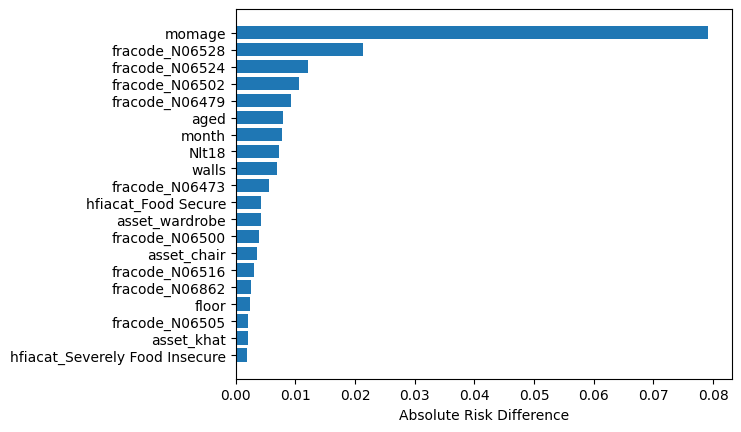

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(dt.df.columns[idx_rank][0:20], diff_rank[0:20], align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Absolute Risk Difference')

plt.savefig("vim_wash.pdf")